In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix

plt.style.use("ggplot")

In [12]:
# First time data load.
movies = pd.read_csv(os.path.join("..", "..", "data", "movielense", "ml-20m", "movies.csv"))
ratings = pd.read_csv(os.path.join("..", "..", "data", "movielense", "ml-20m", "ratings.csv"))

In [13]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies["year"] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format="%Y")
movies.year = movies.year.dt.year
movies.title = movies.title.str[:-7]

In [14]:
# Modify rating timestamp format (from seconds to datetime year)
ratings["date"] = pd.to_datetime(ratings["timestamp"], unit="s", dayfirst=True)
ratings.drop(columns=["timestamp"], inplace=True)

In [15]:
# Check and clean NaN values
print("Number of movies Null values: ", max(movies.isnull().sum()))
print("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

Number of movies Null values:  22
Number of ratings Null values:  0


In [16]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [17]:
ratings.head()

,userId,movieId,rating,date
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


### Users data

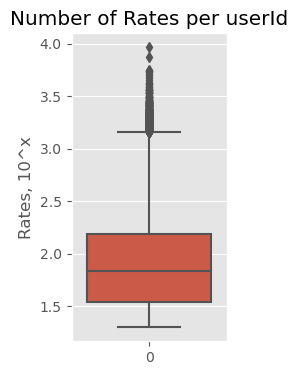

In [18]:
# Count the number of rows for each userId
user_row_counts = ratings.groupby("userId").size()
# Plotting the boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(data=np.log10(ratings.groupby("userId").size().values))
plt.ylabel("Rates, 10^x")
plt.title("Number of Rates per userId")
plt.show()

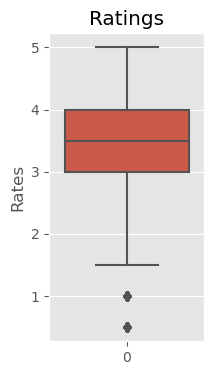

In [19]:
# Plotting the boxplot of rates distribution
plt.figure(figsize=(2, 4))
sns.boxplot(data=ratings.rating.values)
plt.ylabel("Rates")
plt.title("Ratings")
plt.show()

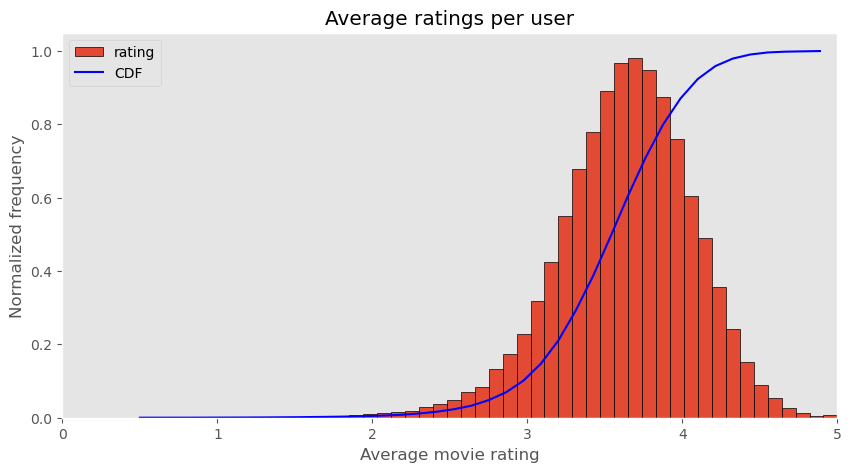

In [20]:
dftmp = ratings[["rating", "userId"]].groupby("userId").mean()
# Plot histogram
dftmp.plot(
    kind="hist", bins=50, grid=0, edgecolor="black", figsize=(10, 5), density=True
)
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, density=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c="blue", label="CDF")
plt.xlim(0, 5)
plt.legend()
plt.xlabel("Average movie rating")
plt.ylabel("Normalized frequency")
plt.title("Average ratings per user")
plt.show()

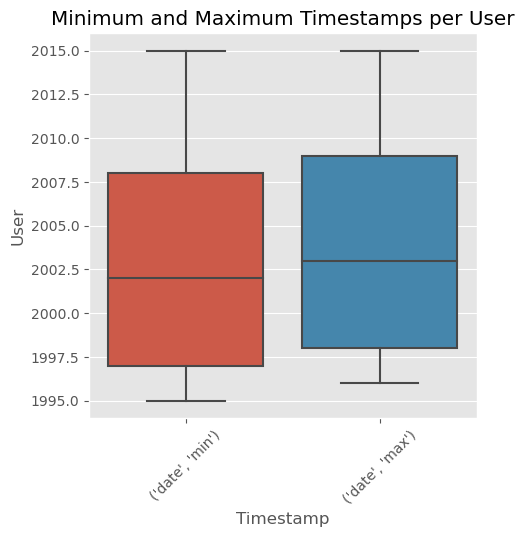

In [21]:
# Getting the minimum and maximum timestamps for each user
user_timestamps = ratings.copy()
user_timestamps.date = user_timestamps.date.dt.year
user_timestamps = (
    user_timestamps[["date", "userId"]].groupby("userId").agg(["min", "max"])
)

# Plotting the boxplots
plt.figure(figsize=(5, 5))
sns.boxplot(data=user_timestamps)
plt.xlabel("Timestamp")
plt.ylabel("User")
plt.title("Minimum and Maximum Timestamps per User")
plt.xticks(rotation=45)
plt.show()

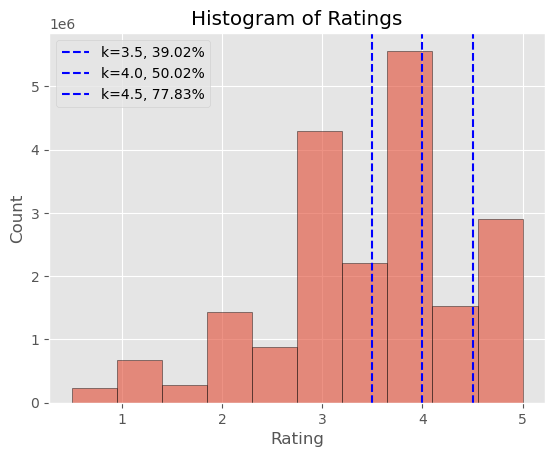

In [22]:
# Create a list of k values
k_values = [3.5, 4.0, 4.5]

# Plot the histogram
plt.hist(ratings["rating"], bins=10, edgecolor="black", alpha=0.6)

for k in k_values:
    # Count the number of ratings less than k
    num_ratings_less_than_k = len(ratings[ratings["rating"] < k])

    # Calculate the total number of ratings
    total_ratings = len(ratings)

    # Calculate the percentage
    percentage_less_than_k = (num_ratings_less_than_k / total_ratings) * 100

    # Plot the vertical line for k
    plt.axvline(
        x=k, color="blue", linestyle="--", label=f"k={k}, {percentage_less_than_k:.2f}%"
    )

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Histogram of Ratings")
plt.legend()
plt.show()

#### Lets make implicit dataset from explicit original one

In [23]:
# remove things < min_rating, and convert to implicit dataset
# by considering ratings as a binary preference only
min_rating = 4
ratings["rating"] = ratings["rating"].apply(lambda x: 0 if x < min_rating else 1)
ratings.reset_index(drop=True, inplace=True)

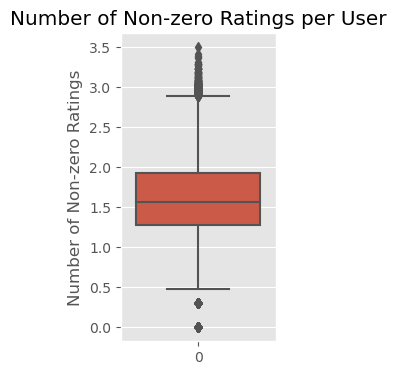

Median number of rates per movie: 37.0


In [24]:
# Filter the ratings DataFrame to include non-zero ratings
non_zero_ratings = ratings[ratings["rating"] != 0]

# Group by userId and calculate the count of non-zero ratings
user_rating_counts = non_zero_ratings.groupby("userId").size()

# Create a boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(data=np.log10(user_rating_counts).values)
plt.ylabel("Number of Non-zero Ratings")
plt.title("Number of Non-zero Ratings per User")
plt.show()

print("Median number of rates per movie:", 10 ** np.log10(user_rating_counts).median())

In [25]:
# Sort the DataFrame by the 'date' column
data = ratings.date.sort_values()

# Calculate the date at the 80th percentile
date_at_80_percentile = data.quantile(0.8)

# Calculate the date at the 90th percentile
date_at_90_percentile = data.quantile(0.9)

print("Date at 80th percentile:", date_at_80_percentile)
print("Date at 90th percentile:", date_at_90_percentile)

Date at 80th percentile: 2009-10-20 07:33:41
Date at 90th percentile: 2012-03-31 00:49:08


# Movies

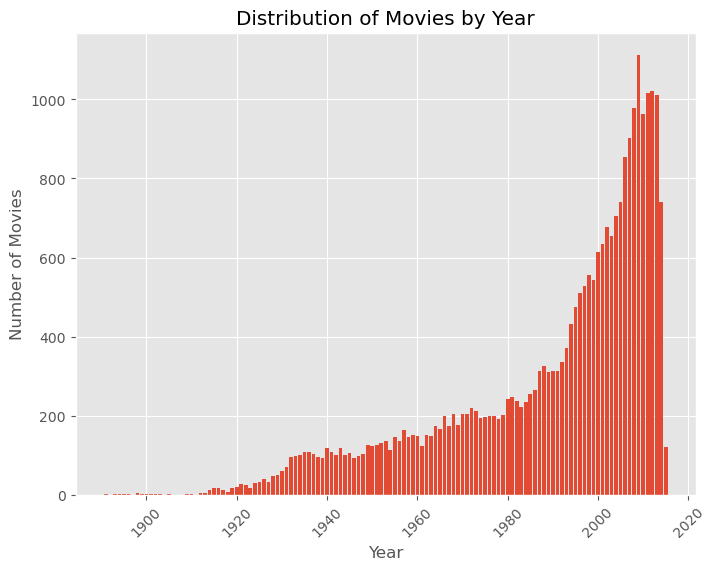

In [26]:
# Count the number of movies for each year
movies_per_year = movies["year"].value_counts().sort_index()

# Plot the distribution of movies by year
plt.figure(figsize=(8, 6))
plt.bar(movies_per_year.index, movies_per_year.values)
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies by Year")
plt.xticks(rotation=45)
plt.show()

#### Both most of the user rating and movie reliases are in between 2000 - 2010

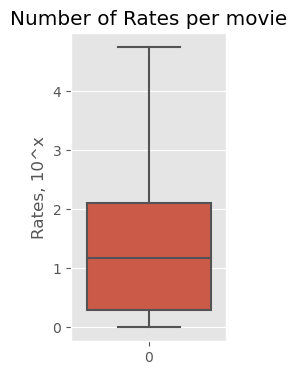

Median number of rates per movie: 15.000000000000004


In [27]:
# Count the number of rows for each movieId
user_row_counts = ratings[ratings.rating != 0].groupby("movieId").size()
# Plotting the boxplot
plt.figure(figsize=(2, 4))
sns.boxplot(data=np.log10(user_row_counts).values)
plt.ylabel("Rates, 10^x")
plt.title("Number of Rates per movie")
plt.show()

print("Median number of rates per movie:", 10 ** np.log10(user_row_counts).median())